# 4. Error Analysis

In [3]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Import our custom analysis frameworks
from explainability_analysis import ExplainabilityAnalyzer, clear_memory, save_intermediate_results,load_intermediate_results
from enhanced_evaluation import ComprehensiveEvaluator

# Memory management utilities
import gc
import pickle
import os

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🔍 Section 4: Error Analysis")
print("Dataset: Online Shoppers Purchasing Intention")

🔍 Section 4: Error Analysis
Dataset: Online Shoppers Purchasing Intention


## 4.1 Load Trained Models and Data

In [4]:
# Load trained models and results from Section 2
try:
    with open('./online_shoppers_section2_results.pkl', 'rb') as f:
        section2_data = pickle.load(f)

    # Extract variables
    models = section2_data['models']
    evaluator = section2_data['evaluator']
    X_train_scaled = section2_data['X_train_scaled']
    X_val_scaled = section2_data['X_val_scaled']
    X_test_scaled = section2_data['X_test_scaled']
    y_train = section2_data['y_train']
    y_val = section2_data['y_val']
    y_test = section2_data['y_test']
    feature_names = section2_data['feature_names']
    month_mapping = section2_data['month_mapping']
    visitor_mapping = section2_data['visitor_mapping']
    class_names = section2_data['class_names']
    label_encoder_month = section2_data['label_encoder_month']
    label_encoder_visitor = section2_data['label_encoder_visitor']
    scaler = section2_data['scaler']
    data_summary = section2_data['data_summary']
    comparison_df = section2_data['comparison_df']

    print("✅ Section 2 results loaded successfully!")
    print(f"Models available: {list(models.keys())}")
    print(f"Features: {len(feature_names)}")
    print(f"Classes: {len(class_names)}")
    print(f"Test samples: {len(X_test_scaled):,}")
    
    # Display feature names for reference
    print(f"\n📋 Feature Names:")
    for i, feature in enumerate(feature_names):
        print(f"   {i+1:2d}. {feature}")

except FileNotFoundError:
    print("❌ Section 2 results not found!")
    print("Please run Section 2 (Model Training) notebook first.")
    raise

✅ Section 2 results loaded successfully!
Models available: ['XGBoost', 'TabPFN v2', 'TabICL', 'FT-Transformer']
Features: 17
Classes: 2
Test samples: 2,466

📋 Feature Names:
    1. Administrative
    2. Administrative_Duration
    3. Informational
    4. Informational_Duration
    5. ProductRelated
    6. ProductRelated_Duration
    7. BounceRates
    8. ExitRates
    9. PageValues
   10. SpecialDay
   11. Month
   12. OperatingSystems
   13. Browser
   14. Region
   15. TrafficType
   16. VisitorType
   17. Weekend


# 4.2 Comprehensive Error Analysis for All Models Including FT-Transformer

This section extends the error analysis to include detailed analysis of all models: XGBoost, TabPFN v2, TabICL, and **FT-Transformer**.

## Analysis Components:
1. **Cross-Model Error Comparison**: Compare error patterns across all models
2. **Model-Specific Error Analysis**: Deep dive into all model errors including FT-Transformer
3. **Confidence Analysis**: Prediction confidence comparison
4. **Feature-based Error Analysis**: Which features cause errors in each model
5. **Error Overlap Analysis**: Common vs unique errors across models
6. **FT-Transformer Specific Analysis**: Transformer-based error patterns

In [5]:
# Import required libraries for comprehensive analysis
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc
from scipy.stats import ttest_ind

print("📊 Extended Error Analysis Framework Loaded")
print("Ready to analyze all model error patterns including FT-Transformer")

# Define model names for analysis
model_names = list(models.keys())
print(f"\n📊 Models available for error analysis: {model_names}")

📊 Extended Error Analysis Framework Loaded
Ready to analyze all model error patterns including FT-Transformer

📊 Models available for error analysis: ['XGBoost', 'TabPFN v2', 'TabICL', 'FT-Transformer']


## 4.2.1. Cross-Model Error Comparison

Get predictions from all models and compare their error patterns.

In [6]:
# Get predictions and probabilities from all models
predictions = {}
probabilities = {}
misclassified_indices = {}

print("🔮 Generating predictions from all models...")

for model_name, model in models.items():
    print(f"   Processing {model_name}...")
    
    # Special handling for FT-Transformer (PyTorch model)
    if 'FT-Transformer' in model_name:
        # FT-Transformer is a PyTorch model, need special handling
        import torch
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        model.eval()
        with torch.no_grad():
            X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
            outputs = model(X_test_tensor, None)  # (numerical_features, categorical_features)
            probas = torch.softmax(outputs, dim=1)
            y_pred = torch.argmax(outputs, dim=1).cpu().numpy()
            y_proba = probas.cpu().numpy()[:, 1]  # Probability of class 1
    else:
        # Standard sklearn-like interface
        y_pred = model.predict(X_test_scaled)
        if hasattr(model, 'predict_proba'):
            y_proba = model.predict_proba(X_test_scaled)[:, 1]
        else:
            y_proba = None
    
    predictions[model_name] = y_pred
    probabilities[model_name] = y_proba
    
    # Find misclassified samples
    misclassified_mask = (y_pred != y_test)
    misclassified_indices[model_name] = np.where(misclassified_mask)[0]
    
    print(f"     Misclassified: {len(misclassified_indices[model_name])} / {len(y_test)} "
          f"({len(misclassified_indices[model_name])/len(y_test)*100:.2f}%)")

print("\n✅ Predictions generated for all models")

🔮 Generating predictions from all models...
   Processing XGBoost...
     Misclassified: 253 / 2466 (10.26%)
   Processing TabPFN v2...
     Misclassified: 244 / 2466 (9.89%)
   Processing TabICL...
     Misclassified: 248 / 2466 (10.06%)
   Processing FT-Transformer...
     Misclassified: 257 / 2466 (10.42%)

✅ Predictions generated for all models


In [7]:
# Create comprehensive error comparison table
error_comparison = []

for model_name in model_names:
    y_pred = predictions[model_name]
    
    # Calculate detailed metrics
    precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    error_comparison.append({
        'Model': model_name,
        'Total_Errors': len(misclassified_indices[model_name]),
        'Error_Rate_%': len(misclassified_indices[model_name])/len(y_test)*100,
        'False_Positives': fp,
        'False_Negatives': fn,
        'FP_Rate_%': fp/(fp+tn)*100,
        'FN_Rate_%': fn/(fn+tp)*100,
        'Precision_Class_0': precision[0],
        'Precision_Class_1': precision[1],
        'Recall_Class_0': recall[0],
        'Recall_Class_1': recall[1],
        'F1_Class_0': f1[0],
        'F1_Class_1': f1[1]
    })

error_df = pd.DataFrame(error_comparison)

print("📊 CROSS-MODEL ERROR COMPARISON (INCLUDING FT-TRANSFORMER)")
print("=" * 80)
print(error_df.round(4).to_string(index=False))

# Save results
error_df.to_csv('./Section4_ErrorAnalysis/cross_model_error_comparison_with_ft_transformer.csv', index=False)
print("\n💾 Results saved to 'cross_model_error_comparison_with_ft_transformer.csv'")

📊 CROSS-MODEL ERROR COMPARISON (INCLUDING FT-TRANSFORMER)
         Model  Total_Errors  Error_Rate_%  False_Positives  False_Negatives  FP_Rate_%  FN_Rate_%  Precision_Class_0  Precision_Class_1  Recall_Class_0  Recall_Class_1  F1_Class_0  F1_Class_1
       XGBoost           253       10.2595               87              166     4.1747    43.4555             0.9233             0.7129          0.9583          0.5654      0.9404      0.6307
     TabPFN v2           244        9.8946               88              156     4.2226    40.8377             0.9275             0.7197          0.9578          0.5916      0.9424      0.6494
        TabICL           248       10.0568               89              159     4.2706    41.6230             0.9262             0.7147          0.9573          0.5838      0.9415      0.6427
FT-Transformer           257       10.4217              110              147     5.2783    38.4817             0.9307             0.6812          0.9472          0.6152  

## 4.2.2. Model-Specific Error Insights

Generate detailed insights for all models


🔍 MODEL-SPECIFIC ERROR INSIGHTS

📊 XGBOOST ERROR ANALYSIS
------------------------------------------------------------
Total Errors: 253 (10.26%)
Confusion Matrix Analysis:
  True Negatives (Correct No Purchase): 1997
  False Positives (Incorrect Purchase): 87
  False Negatives (Missed Purchase): 166
  True Positives (Correct Purchase): 216
  Sensitivity (True Positive Rate): 0.5654
  Specificity (True Negative Rate): 0.9583
  False Positive Rate: 0.0417
  False Negative Rate: 0.4346
Confidence Analysis:
  Average Confidence (Correct): 0.9398
  Average Confidence (Errors): 0.7673
  Low Confidence Errors (<60%): 17.0%


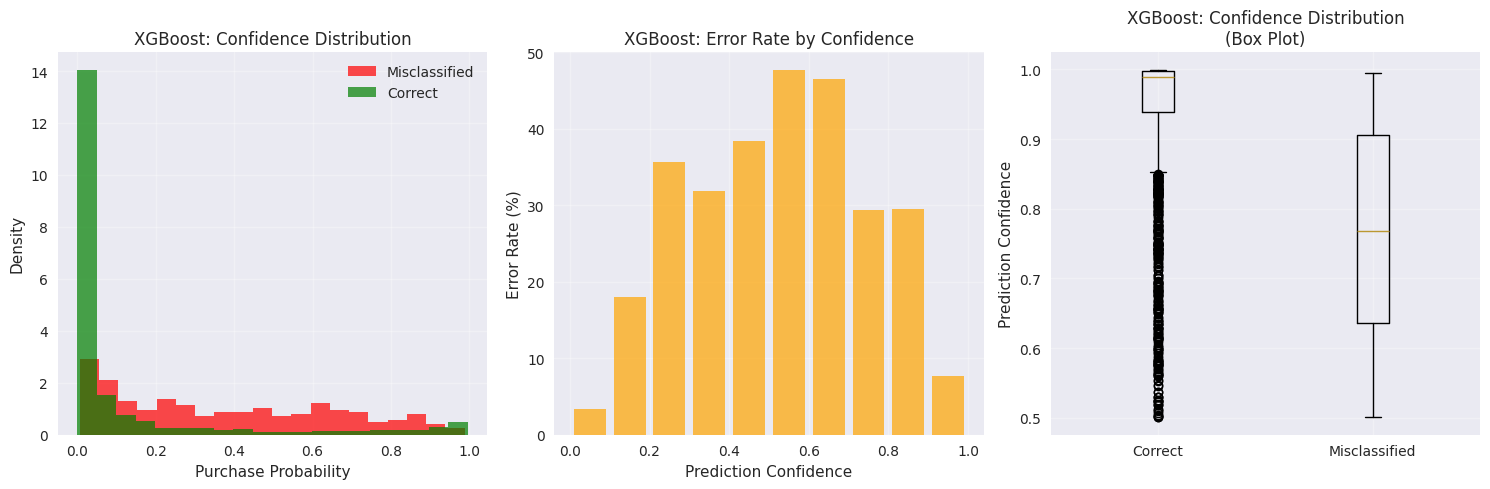


🌳 XGBoost-Specific Insights:
  - Tree-based errors often indicate feature interaction issues
  - Consider feature engineering or hyperparameter tuning
  - May benefit from ensemble methods

📊 TABPFN V2 ERROR ANALYSIS
------------------------------------------------------------
Total Errors: 244 (9.89%)
Confusion Matrix Analysis:
  True Negatives (Correct No Purchase): 1996
  False Positives (Incorrect Purchase): 88
  False Negatives (Missed Purchase): 156
  True Positives (Correct Purchase): 226
  Sensitivity (True Positive Rate): 0.5916
  Specificity (True Negative Rate): 0.9578
  False Positive Rate: 0.0422
  False Negative Rate: 0.4084
Confidence Analysis:
  Average Confidence (Correct): 0.9357
  Average Confidence (Errors): 0.7371
  Low Confidence Errors (<60%): 27.5%


<Figure size 800x550 with 0 Axes>

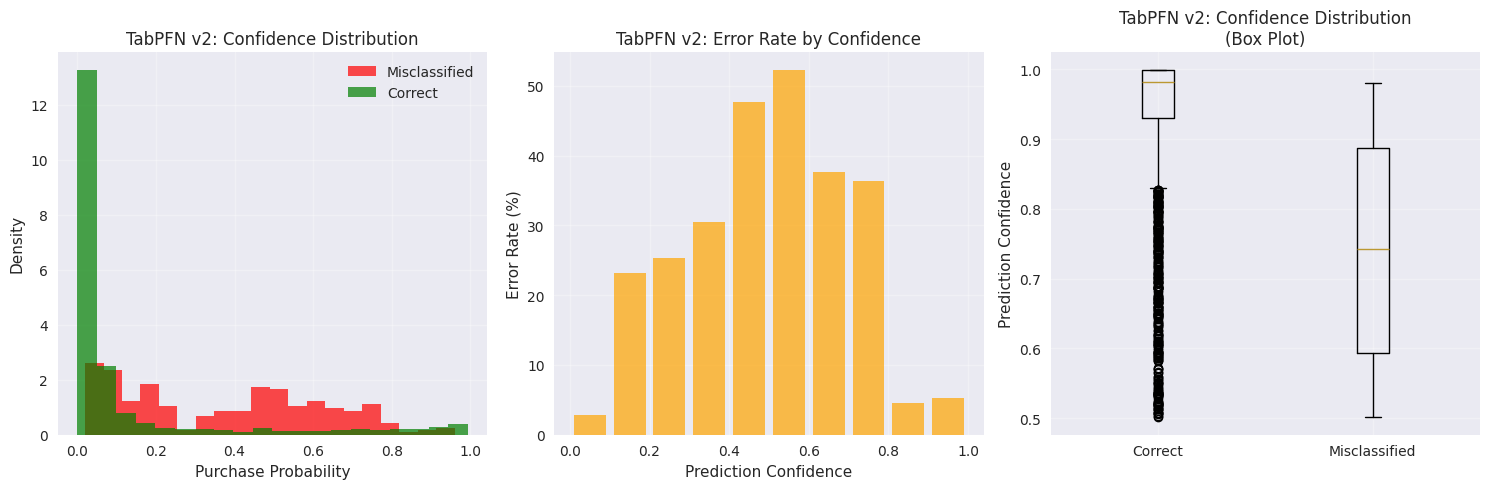


🧠 TabPFN-Specific Insights:
  - Prior-based predictions may struggle with out-of-distribution samples
  - Consider context size optimization for better performance
  - Errors may indicate dataset shift from pretraining distribution

📊 TABICL ERROR ANALYSIS
------------------------------------------------------------
Total Errors: 248 (10.06%)
Confusion Matrix Analysis:
  True Negatives (Correct No Purchase): 1995
  False Positives (Incorrect Purchase): 89
  False Negatives (Missed Purchase): 159
  True Positives (Correct Purchase): 223
  Sensitivity (True Positive Rate): 0.5838
  Specificity (True Negative Rate): 0.9573
  False Positive Rate: 0.0427
  False Negative Rate: 0.4162
Confidence Analysis:
  Average Confidence (Correct): 0.9348
  Average Confidence (Errors): 0.7240
  Low Confidence Errors (<60%): 28.2%


<Figure size 800x550 with 0 Axes>

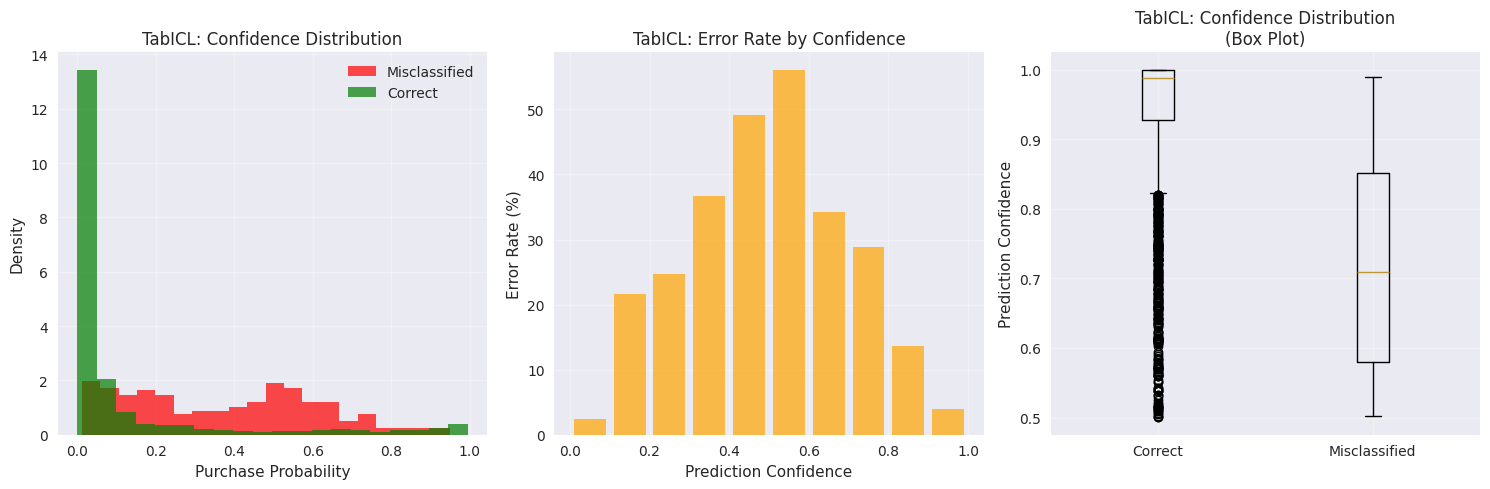


🎯 TabICL-Specific Insights:
  - In-context learning errors may indicate poor example selection
  - Consider diverse example selection strategies
  - Context window utilization may need optimization

📊 FT-TRANSFORMER ERROR ANALYSIS
------------------------------------------------------------
Total Errors: 257 (10.42%)
Confusion Matrix Analysis:
  True Negatives (Correct No Purchase): 1974
  False Positives (Incorrect Purchase): 110
  False Negatives (Missed Purchase): 147
  True Positives (Correct Purchase): 235
  Sensitivity (True Positive Rate): 0.6152
  Specificity (True Negative Rate): 0.9472
  False Positive Rate: 0.0528
  False Negative Rate: 0.3848
Confidence Analysis:
  Average Confidence (Correct): 0.9367
  Average Confidence (Errors): 0.7428
  Low Confidence Errors (<60%): 24.1%


<Figure size 800x550 with 0 Axes>

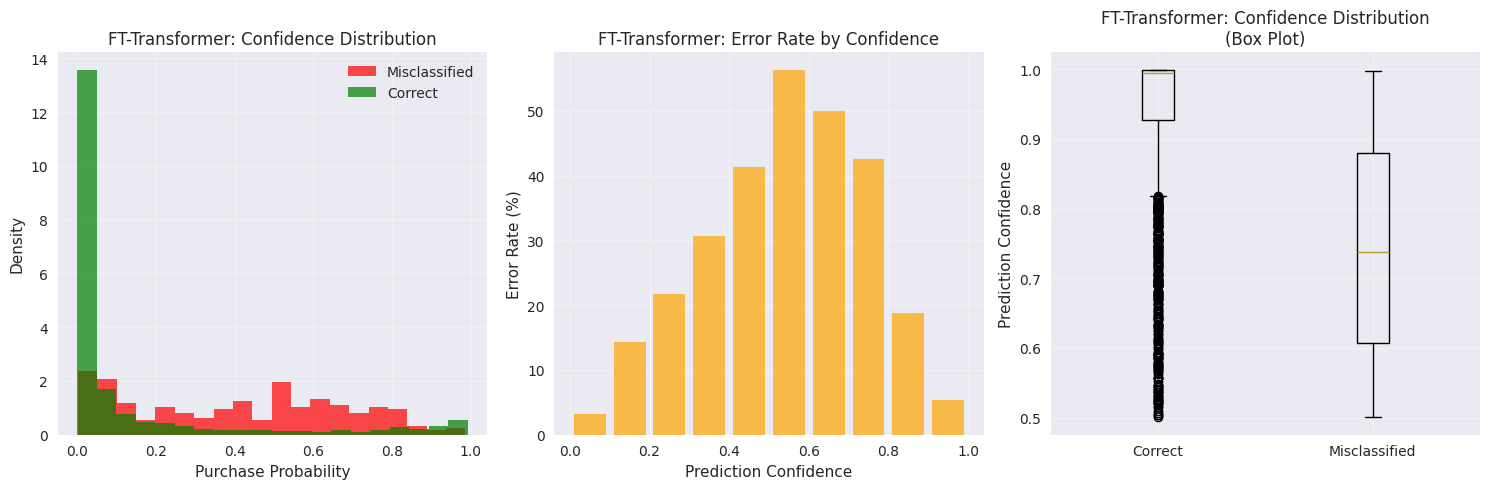


🤖 FT-Transformer-Specific Insights:
  - Transformer attention mechanisms may struggle with certain feature combinations
  - Self-attention patterns could reveal which features interact poorly
  - Consider analyzing attention weights for misclassified samples
  - Feature tokenization may not capture optimal representations
  - Deep architecture allows complex feature interactions but may overfit


<Figure size 800x550 with 0 Axes>

In [9]:
# Generate model-specific error insights
print("🔍 MODEL-SPECIFIC ERROR INSIGHTS")
print("=" * 80)

for model_name in model_names:
    print(f"\n📊 {model_name.upper()} ERROR ANALYSIS")
    print("-" * 60)
    
    # Basic error statistics
    total_errors = len(misclassified_indices[model_name])
    error_rate = total_errors / len(y_test) * 100
    
    print(f"Total Errors: {total_errors} ({error_rate:.2f}%)")
    
    # Confusion matrix analysis
    y_pred = predictions[model_name]
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    print(f"Confusion Matrix Analysis:")
    print(f"  True Negatives (Correct No Purchase): {tn}")
    print(f"  False Positives (Incorrect Purchase): {fp}")
    print(f"  False Negatives (Missed Purchase): {fn}")
    print(f"  True Positives (Correct Purchase): {tp}")
    print(f"  Sensitivity (True Positive Rate): {tp/(tp+fn):.4f}")
    print(f"  Specificity (True Negative Rate): {tn/(tn+fp):.4f}")
    print(f"  False Positive Rate: {fp/(fp+tn):.4f}")
    print(f"  False Negative Rate: {fn/(fn+tp):.4f}")
    
    # Confidence analysis (if available)
    if probabilities[model_name] is not None:
        y_proba = probabilities[model_name]
        misclassified_mask = (y_pred != y_test)
        
        misclassified_proba = y_proba[misclassified_mask]
        correct_proba = y_proba[~misclassified_mask]
        
        avg_conf_correct = np.mean(np.maximum(correct_proba, 1-correct_proba))
        avg_conf_errors = np.mean(np.maximum(misclassified_proba, 1-misclassified_proba))
        low_conf_errors = np.mean(np.maximum(misclassified_proba, 1-misclassified_proba) < 0.6) * 100
        
        print(f"Confidence Analysis:")
        print(f"  Average Confidence (Correct): {avg_conf_correct:.4f}")
        print(f"  Average Confidence (Errors): {avg_conf_errors:.4f}")
        print(f"  Low Confidence Errors (<60%): {low_conf_errors:.1f}%")
    
     # Visualize confidence distributions
    plt.figure(figsize=(15, 5))
    
    # Confidence distribution
    plt.subplot(1, 3, 1)
    plt.hist(misclassified_proba, bins=20, alpha=0.7, label='Misclassified', 
             color='red', density=True)
    plt.hist(correct_proba, bins=20, alpha=0.7, label='Correct', 
             color='green', density=True)
    plt.xlabel('Purchase Probability')
    plt.ylabel('Density')
    plt.title(f'{model_name}: Confidence Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Confidence vs accuracy by bins
    plt.subplot(1, 3, 2)
    confidence_bins = np.linspace(0, 1, 11)
    bin_centers = (confidence_bins[:-1] + confidence_bins[1:]) / 2
    
    total_counts = np.histogram(y_proba, bins=confidence_bins)[0]
    error_counts = np.histogram(y_proba[misclassified_mask], bins=confidence_bins)[0]
    error_rates = np.divide(error_counts, total_counts, 
                           out=np.zeros_like(error_counts, dtype=float), 
                           where=total_counts!=0)
    
    plt.bar(bin_centers, error_rates * 100, width=0.08, alpha=0.7, color='orange')
    plt.xlabel('Prediction Confidence')
    plt.ylabel('Error Rate (%)')
    plt.title(f'{model_name}: Error Rate by Confidence')
    plt.grid(True, alpha=0.3)
    
    # Confidence difference analysis
    plt.subplot(1, 3, 3)
    confidence_correct = np.maximum(correct_proba, 1-correct_proba)
    confidence_errors = np.maximum(misclassified_proba, 1-misclassified_proba)
    
    plt.boxplot([confidence_correct, confidence_errors], 
                labels=['Correct', 'Misclassified'])
    plt.ylabel('Prediction Confidence')
    plt.title(f'{model_name}: Confidence Distribution\n(Box Plot)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'Section4_ErrorAnalysis/{model_name}_Confidence_Analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    
    # Model-specific insights
    if 'FT-Transformer' in model_name:
        print("\n🤖 FT-Transformer-Specific Insights:")
        print("  - Transformer attention mechanisms may struggle with certain feature combinations")
        print("  - Self-attention patterns could reveal which features interact poorly")
        print("  - Consider analyzing attention weights for misclassified samples")
        print("  - Feature tokenization may not capture optimal representations")
        print("  - Deep architecture allows complex feature interactions but may overfit")
    elif 'TabPFN' in model_name:
        print("\n🧠 TabPFN-Specific Insights:")
        print("  - Prior-based predictions may struggle with out-of-distribution samples")
        print("  - Consider context size optimization for better performance")
        print("  - Errors may indicate dataset shift from pretraining distribution")
    elif 'TabICL' in model_name:
        print("\n🎯 TabICL-Specific Insights:")
        print("  - In-context learning errors may indicate poor example selection")
        print("  - Consider diverse example selection strategies")
        print("  - Context window utilization may need optimization")
    elif 'XGBoost' in model_name:
        print("\n🌳 XGBoost-Specific Insights:")
        print("  - Tree-based errors often indicate feature interaction issues")
        print("  - Consider feature engineering or hyperparameter tuning")
        print("  - May benefit from ensemble methods")

Specific Error Analysis For XGBOOST


ERROR ANALYSIS
Total misclassified samples: 253 out of 2466
Misclassification rate: 10.26%


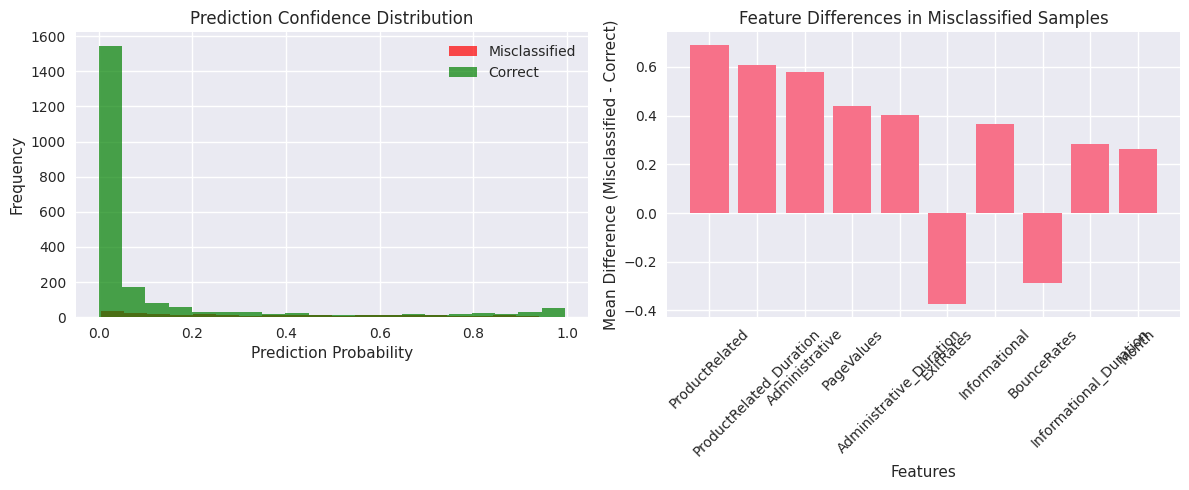


Top 5 features with largest differences in misclassified samples:
   1. ProductRelated: 0.6888
   2. ProductRelated_Duration: 0.6073
   3. Administrative: 0.5784
   4. PageValues: 0.4411
   5. Administrative_Duration: 0.4041


<Figure size 800x550 with 0 Axes>

In [10]:
# Analyze misclassified samples
print("\n" + "="*60)
print("ERROR ANALYSIS")
print("="*60)

# Focus on XGBoost for detailed error analysis
xgb_pred = models['XGBoost'].predict(X_test_scaled)
xgb_proba = models['XGBoost'].predict_proba(X_test_scaled)[:, 1]

# Find misclassified samples
misclassified_mask = (xgb_pred != y_test)
xgb_misclassified_indices = misclassified_indices['XGBoost']#np.where(misclassified_mask)[0]

print(f"Total misclassified samples: {len(xgb_misclassified_indices)} out of {len(y_test)}")
print(f"Misclassification rate: {len(xgb_misclassified_indices)/len(y_test)*100:.2f}%")

# Analyze confidence of misclassified samples
misclassified_proba = xgb_proba[misclassified_mask]
correct_proba = xgb_proba[~misclassified_mask]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(misclassified_proba, bins=20, alpha=0.7, label='Misclassified', color='red')
plt.hist(correct_proba, bins=20, alpha=0.7, label='Correct', color='green')
plt.xlabel('Prediction Probability')
plt.ylabel('Frequency')
plt.title('Prediction Confidence Distribution')
plt.legend()

plt.subplot(1, 2, 2)
# Feature importance for misclassified samples
misclassified_features = X_test_scaled[misclassified_mask]
correct_features = X_test_scaled[~misclassified_mask]

feature_diff = np.mean(misclassified_features, axis=0) - np.mean(correct_features, axis=0)
sorted_indices = np.argsort(np.abs(feature_diff))[::-1][:10]

plt.bar(range(10), feature_diff[sorted_indices])
plt.xlabel('Features')
plt.ylabel('Mean Difference (Misclassified - Correct)')
plt.title('Feature Differences in Misclassified Samples')
plt.xticks(range(10), [feature_names[i] for i in sorted_indices], rotation=45)

plt.tight_layout()
plt.savefig('./Section4_ErrorAnalysis/XGBoost_Detailed_Error_Analysis.png')
plt.show()


print(f"\nTop 5 features with largest differences in misclassified samples:")
for i, idx in enumerate(sorted_indices[:5]):
    print(f"   {i+1}. {feature_names[idx]}: {feature_diff[idx]:.4f}")

Specific Error Analysis For FT-Transformer

Deep dive into FT-Transformer error patterns and characteristics.

🤖 DETAILED FT-TRANSFORMER ERROR ANALYSIS

FT-Transformer Feature Analysis:
Significant features (p < 0.05): 12/17

Top 5 problematic features for FT-Transformer:
  1. ProductRelated: diff=0.7216, p=0.0000
  2. ProductRelated_Duration: diff=0.6221, p=0.0000
  3. PageValues: diff=0.5472, p=0.0000
  4. Administrative: diff=0.5166, p=0.0000
  5. Administrative_Duration: diff=0.4560, p=0.0000


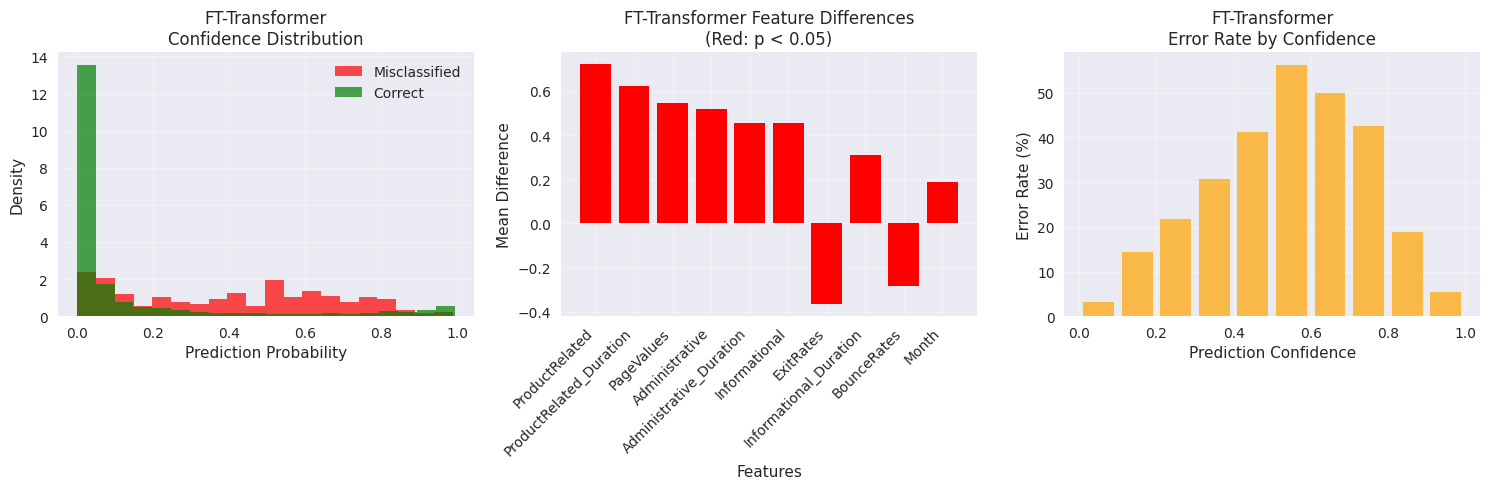


🎯 FT-Transformer Error Summary:
   Total misclassified: 257 (10.42%)
   Most problematic features: ['ProductRelated', 'ProductRelated_Duration', 'PageValues']
   Average confidence on errors: 0.7428
   Low confidence errors: 24.1%


In [11]:
# FT-Transformer specific error analysis
if 'FT-Transformer' in model_names:
    print("🤖 DETAILED FT-TRANSFORMER ERROR ANALYSIS")
    print("=" * 60)
    
    ft_pred = predictions['FT-Transformer']
    ft_proba = probabilities['FT-Transformer']
    ft_misclassified = misclassified_indices['FT-Transformer']
    
    # Feature-based error analysis for FT-Transformer
    misclassified_mask = (ft_pred != y_test)
    misclassified_features = X_test_scaled[misclassified_mask]
    correct_features = X_test_scaled[~misclassified_mask]
    
    # Calculate feature differences
    feature_diff = np.mean(misclassified_features, axis=0) - np.mean(correct_features, axis=0)
    
    # Statistical significance test
    p_values = []
    for i in range(len(feature_names)):
        _, p_val = ttest_ind(misclassified_features[:, i], correct_features[:, i])
        p_values.append(p_val)
    
    # Find significant features
    significant_indices = np.where(np.array(p_values) < 0.05)[0]
    
    print(f"\nFT-Transformer Feature Analysis:")
    print(f"Significant features (p < 0.05): {len(significant_indices)}/{len(feature_names)}")
    
    if len(significant_indices) > 0:
        sorted_sig_indices = significant_indices[np.argsort(np.abs(feature_diff[significant_indices]))[::-1]]
        
        print(f"\nTop 5 problematic features for FT-Transformer:")
        for i, idx in enumerate(sorted_sig_indices[:5]):
            print(f"  {i+1}. {feature_names[idx]}: diff={feature_diff[idx]:.4f}, p={p_values[idx]:.4f}")
    
    # Confidence distribution analysis
    if ft_proba is not None:
        plt.figure(figsize=(15, 5))
        
        # Confidence distribution
        plt.subplot(1, 3, 1)
        misclassified_proba = ft_proba[misclassified_mask]
        correct_proba = ft_proba[~misclassified_mask]
        
        plt.hist(misclassified_proba, bins=20, alpha=0.7, label='Misclassified', color='red', density=True)
        plt.hist(correct_proba, bins=20, alpha=0.7, label='Correct', color='green', density=True)
        plt.xlabel('Prediction Probability')
        plt.ylabel('Density')
        plt.title('FT-Transformer\nConfidence Distribution')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Feature differences visualization
        plt.subplot(1, 3, 2)
        sorted_indices = np.argsort(np.abs(feature_diff))[::-1][:10]
        colors = ['red' if p_values[i] < 0.05 else 'lightblue' for i in sorted_indices]
        
        plt.bar(range(10), feature_diff[sorted_indices], color=colors)
        plt.xlabel('Features')
        plt.ylabel('Mean Difference')
        plt.title('FT-Transformer Feature Differences\n(Red: p < 0.05)')
        plt.xticks(range(10), [feature_names[i] for i in sorted_indices], rotation=45, ha='right')
        plt.grid(True, alpha=0.3)
        
        # Error distribution by confidence
        plt.subplot(1, 3, 3)
        confidence_bins = np.linspace(0, 1, 11)
        bin_centers = (confidence_bins[:-1] + confidence_bins[1:]) / 2
        
        total_counts = np.histogram(ft_proba, bins=confidence_bins)[0]
        error_counts = np.histogram(ft_proba[misclassified_mask], bins=confidence_bins)[0]
        error_rates = np.divide(error_counts, total_counts, out=np.zeros_like(error_counts, dtype=float), where=total_counts!=0)
        
        plt.bar(bin_centers, error_rates * 100, width=0.08, alpha=0.7, color='orange')
        plt.xlabel('Prediction Confidence')
        plt.ylabel('Error Rate (%)')
        plt.title('FT-Transformer\nError Rate by Confidence')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('./Section4_ErrorAnalysis/ft_transformer_detailed_error_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    print(f"\n🎯 FT-Transformer Error Summary:")
    print(f"   Total misclassified: {len(ft_misclassified)} ({len(ft_misclassified)/len(y_test)*100:.2f}%)")
    print(f"   Most problematic features: {[feature_names[i] for i in sorted_sig_indices[:3]] if len(significant_indices) > 0 else 'None significant'}")
    if ft_proba is not None:
        print(f"   Average confidence on errors: {np.mean(np.maximum(misclassified_proba, 1-misclassified_proba)):.4f}")
        print(f"   Low confidence errors: {np.mean(np.maximum(misclassified_proba, 1-misclassified_proba) < 0.6)*100:.1f}%")
else:
    print("⚠️ FT-Transformer not found in models")

Error Analysis for TabICL

🔍 TabICL Feature-based Error Analysis

📊 TabICL Feature Analysis Results:
   Total features analyzed: 17
   Statistically significant features (p < 0.05): 12

🎯 Top 10 Most Problematic Features for TabICL:
    1. ProductRelated      : diff= 0.7216, p=0.0000, effect_size=0.6668
    2. ProductRelated_Duration: diff= 0.6221, p=0.0000, effect_size=0.6402
    3. PageValues          : diff= 0.5472, p=0.0000, effect_size=0.5635
    4. Administrative      : diff= 0.5166, p=0.0000, effect_size=0.5221
    5. Administrative_Duration: diff= 0.4560, p=0.0000, effect_size=0.5013
    6. Informational       : diff= 0.4559, p=0.0000, effect_size=0.4767
    7. ExitRates           : diff=-0.3663, p=0.0000, effect_size=0.3843
    8. Informational_Duration: diff= 0.3113, p=0.0000, effect_size=0.3263
    9. BounceRates         : diff=-0.2823, p=0.0000, effect_size=0.2965
   10. SpecialDay          : diff=-0.1757, p=0.0039, effect_size=0.1906


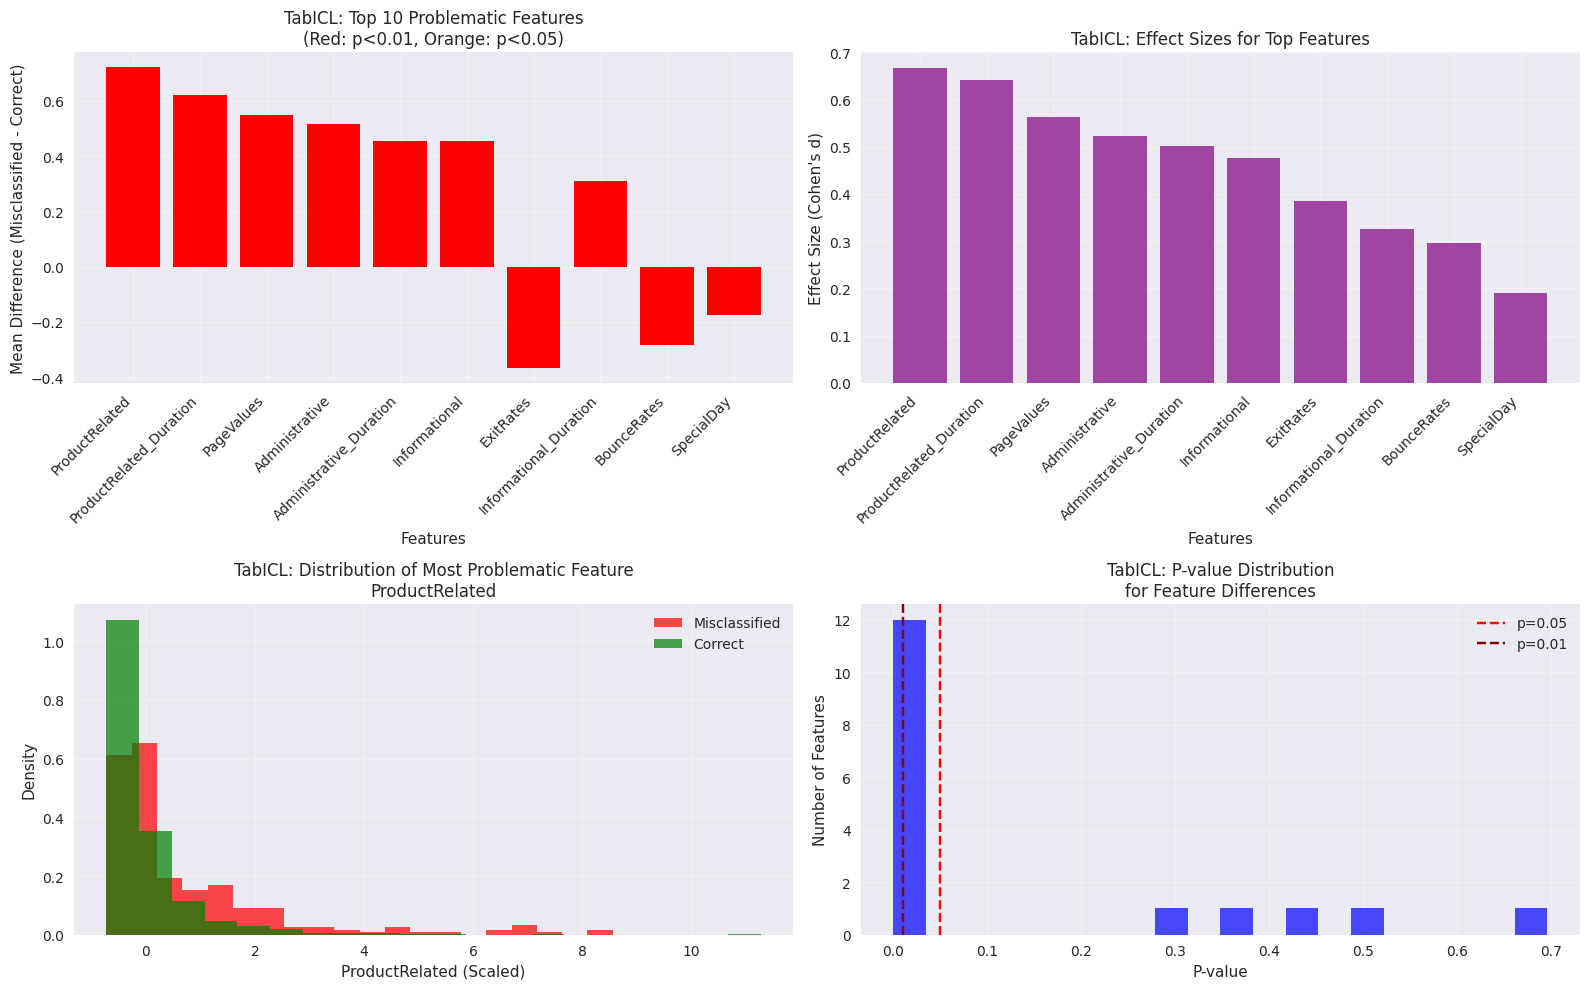


💾 Feature analysis results saved to 'TabICL_feature_error_analysis.csv'


In [13]:
# Analyze which features are most associated with TabICL errors
print("🔍 TabICL Feature-based Error Analysis")
print("=" * 50)

if np.sum(misclassified_mask) > 0:
    misclassified_features = X_test_scaled[misclassified_mask]
    correct_features = X_test_scaled[~misclassified_mask]
    
    # Calculate feature differences
    feature_diff = np.mean(misclassified_features, axis=0) - np.mean(correct_features, axis=0)
    feature_std_diff = np.std(misclassified_features, axis=0) - np.std(correct_features, axis=0)
    
    # Statistical significance test (t-test)
    p_values = []
    effect_sizes = []
    for i in range(len(feature_names)):
        # T-test
        _, p_val = ttest_ind(misclassified_features[:, i], correct_features[:, i])
        p_values.append(p_val)
        
        # Effect size (Cohen's d)
        pooled_std = np.sqrt(((len(misclassified_features) - 1) * np.var(misclassified_features[:, i]) + 
                             (len(correct_features) - 1) * np.var(correct_features[:, i])) / 
                            (len(misclassified_features) + len(correct_features) - 2))
        cohens_d = feature_diff[i] / pooled_std if pooled_std > 0 else 0
        effect_sizes.append(abs(cohens_d))
    
    p_values = np.array(p_values)
    effect_sizes = np.array(effect_sizes)
    
    # Find significant features
    significant_indices = np.where(p_values < 0.05)[0]
    
    print(f"\n📊 TabICL Feature Analysis Results:")
    print(f"   Total features analyzed: {len(feature_names)}")
    print(f"   Statistically significant features (p < 0.05): {len(significant_indices)}")
    
    if len(significant_indices) > 0:
        # Sort by effect size for significant features
        sorted_sig_indices = significant_indices[np.argsort(effect_sizes[significant_indices])[::-1]]
        
        print(f"\n🎯 Top 10 Most Problematic Features for TabICL:")
        for i, idx in enumerate(sorted_sig_indices[:10]):
            print(f"   {i+1:2d}. {feature_names[idx]:20s}: "
                  f"diff={feature_diff[idx]:7.4f}, "
                  f"p={p_values[idx]:.4f}, "
                  f"effect_size={effect_sizes[idx]:.4f}")
        
        # Visualize feature differences
        plt.figure(figsize=(16, 10))
        
        # Top problematic features
        plt.subplot(2, 2, 1)
        top_indices = sorted_sig_indices[:10]
        colors = ['red' if p_values[i] < 0.01 else 'orange' for i in top_indices]
        
        bars = plt.bar(range(len(top_indices)), feature_diff[top_indices], color=colors)
        plt.xlabel('Features')
        plt.ylabel('Mean Difference (Misclassified - Correct)')
        plt.title('TabICL: Top 10 Problematic Features\n(Red: p<0.01, Orange: p<0.05)')
        plt.xticks(range(len(top_indices)), 
                   [feature_names[i] for i in top_indices], 
                   rotation=45, ha='right')
        plt.grid(True, alpha=0.3)
        
        # Effect sizes
        plt.subplot(2, 2, 2)
        plt.bar(range(len(top_indices)), effect_sizes[top_indices], color='purple', alpha=0.7)
        plt.xlabel('Features')
        plt.ylabel('Effect Size (Cohen\'s d)')
        plt.title('TabICL: Effect Sizes for Top Features')
        plt.xticks(range(len(top_indices)), 
                   [feature_names[i] for i in top_indices], 
                   rotation=45, ha='right')
        plt.grid(True, alpha=0.3)
        
        # Feature distribution comparison for top feature
        plt.subplot(2, 2, 3)
        top_feature_idx = sorted_sig_indices[0]
        plt.hist(misclassified_features[:, top_feature_idx], bins=20, alpha=0.7, 
                 label='Misclassified', color='red', density=True)
        plt.hist(correct_features[:, top_feature_idx], bins=20, alpha=0.7, 
                 label='Correct', color='green', density=True)
        plt.xlabel(f'{feature_names[top_feature_idx]} (Scaled)')
        plt.ylabel('Density')
        plt.title(f'TabICL: Distribution of Most Problematic Feature\n{feature_names[top_feature_idx]}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # P-value distribution
        plt.subplot(2, 2, 4)
        plt.hist(p_values, bins=20, alpha=0.7, color='blue')
        plt.axvline(x=0.05, color='red', linestyle='--', label='p=0.05')
        plt.axvline(x=0.01, color='darkred', linestyle='--', label='p=0.01')
        plt.xlabel('P-value')
        plt.ylabel('Number of Features')
        plt.title('TabICL: P-value Distribution\nfor Feature Differences')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('./Section4_ErrorAnalysis/TabICL_feature_error_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Create detailed feature analysis table
        feature_analysis_df = pd.DataFrame({
            'Feature': feature_names,
            'Mean_Difference': feature_diff,
            'Std_Difference': feature_std_diff,
            'P_Value': p_values,
            'Effect_Size': effect_sizes,
            'Significant': p_values < 0.05
        })
        
        # Sort by effect size
        feature_analysis_df = feature_analysis_df.sort_values('Effect_Size', ascending=False)
        
        # Save results
        feature_analysis_df.to_csv('./Section4_ErrorAnalysis/TabICL_feature_error_analysis.csv', index=False)
        print(f"\n💾 Feature analysis results saved to 'TabICL_feature_error_analysis.csv'")
        
    else:
        print(f"\n⚠️ No statistically significant feature differences found")
        print(f"TabICL errors may be more related to context patterns than individual features")
        
else:
    print(f"\n⚠️ No misclassified samples found for TabICL")
    print(f"Perfect classification achieved!")

Feature-based Error Analysis for TabPFNV2

🧠 TabPFNV2 Feature-based Error Analysis

📊 TabPFNV2 Feature Analysis Results:
   Total features analyzed: 17
   Statistically significant features (p < 0.05): 11

🎯 Top 10 Most Problematic Features for TabPFNV2:
    1. PageValues          : diff= 0.5401, p=0.0000, effect_size=0.5555
    2. ProductRelated      : diff= 0.5894, p=0.0000, effect_size=0.5405
    3. ProductRelated_Duration: diff= 0.4982, p=0.0000, effect_size=0.5089
    4. Administrative      : diff= 0.4957, p=0.0000, effect_size=0.5003
    5. ExitRates           : diff=-0.3465, p=0.0000, effect_size=0.3632
    6. Administrative_Duration: diff= 0.3158, p=0.0000, effect_size=0.3450
    7. BounceRates         : diff=-0.2744, p=0.0000, effect_size=0.2880
    8. Informational       : diff= 0.2751, p=0.0000, effect_size=0.2856
    9. SpecialDay          : diff=-0.2033, p=0.0011, effect_size=0.2206
   10. Month               : diff= 0.2119, p=0.0017, effect_size=0.2124


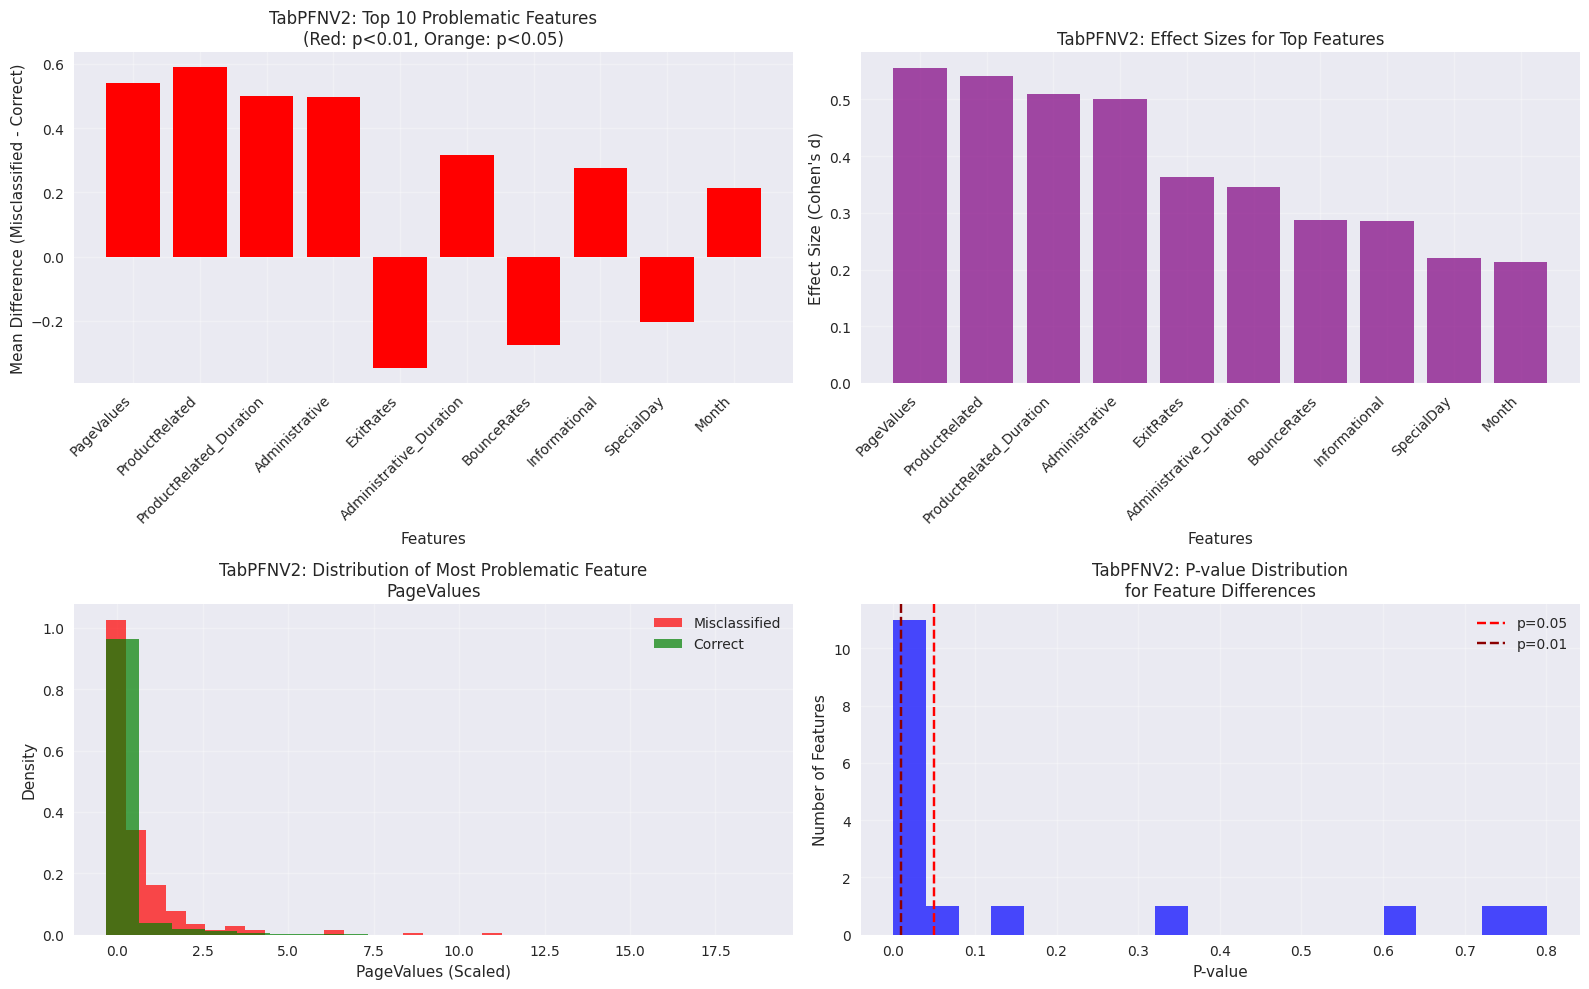


💾 Feature analysis results saved to 'TabPFNV2_feature_error_analysis.csv'

🧠 TabPFNV2-Specific Insights:
  - Prior-based predictions may struggle with out-of-distribution samples
  - Consider context size optimization for better performance
  - Errors may indicate dataset shift from pretraining distribution
  - Feature interactions captured by priors may not align with this dataset
  - Consider fine-tuning or domain adaptation strategies

📊 TabPFNV2 Confidence Analysis:
   Average confidence (correct predictions): 0.9357
   Average confidence (errors): 0.7371
   Low confidence errors (<60%): 27.5%


In [14]:
# TabPFNV2 Feature-based Error Analysis
print("🧠 TabPFNV2 Feature-based Error Analysis")
print("=" * 50)

# Get TabPFNV2 predictions and misclassified samples
tabpfn_pred = predictions['TabPFN v2']
tabpfn_proba = probabilities['TabPFN v2']
tabpfn_misclassified = misclassified_indices['TabPFN v2']

# Create misclassified mask
misclassified_mask = (tabpfn_pred != y_test)

if np.sum(misclassified_mask) > 0:
    misclassified_features = X_test_scaled[misclassified_mask]
    correct_features = X_test_scaled[~misclassified_mask]
    
    # Calculate feature differences
    feature_diff = np.mean(misclassified_features, axis=0) - np.mean(correct_features, axis=0)
    feature_std_diff = np.std(misclassified_features, axis=0) - np.std(correct_features, axis=0)
    
    # Statistical significance test (t-test)
    p_values = []
    effect_sizes = []
    for i in range(len(feature_names)):
        # T-test
        _, p_val = ttest_ind(misclassified_features[:, i], correct_features[:, i])
        p_values.append(p_val)
        
        # Effect size (Cohen's d)
        pooled_std = np.sqrt(((len(misclassified_features) - 1) * np.var(misclassified_features[:, i]) + 
                             (len(correct_features) - 1) * np.var(correct_features[:, i])) / 
                            (len(misclassified_features) + len(correct_features) - 2))
        cohens_d = feature_diff[i] / pooled_std if pooled_std > 0 else 0
        effect_sizes.append(abs(cohens_d))
    
    p_values = np.array(p_values)
    effect_sizes = np.array(effect_sizes)
    
    # Find significant features
    significant_indices = np.where(p_values < 0.05)[0]
    
    print(f"\n📊 TabPFNV2 Feature Analysis Results:")
    print(f"   Total features analyzed: {len(feature_names)}")
    print(f"   Statistically significant features (p < 0.05): {len(significant_indices)}")
    
    if len(significant_indices) > 0:
        # Sort by effect size for significant features
        sorted_sig_indices = significant_indices[np.argsort(effect_sizes[significant_indices])[::-1]]
        
        print(f"\n🎯 Top 10 Most Problematic Features for TabPFNV2:")
        for i, idx in enumerate(sorted_sig_indices[:10]):
            print(f"   {i+1:2d}. {feature_names[idx]:20s}: "
                  f"diff={feature_diff[idx]:7.4f}, "
                  f"p={p_values[idx]:.4f}, "
                  f"effect_size={effect_sizes[idx]:.4f}")
        
        # Visualize feature differences
        plt.figure(figsize=(16, 10))
        
        # Top problematic features
        plt.subplot(2, 2, 1)
        top_indices = sorted_sig_indices[:10]
        colors = ['red' if p_values[i] < 0.01 else 'orange' for i in top_indices]
        
        bars = plt.bar(range(len(top_indices)), feature_diff[top_indices], color=colors)
        plt.xlabel('Features')
        plt.ylabel('Mean Difference (Misclassified - Correct)')
        plt.title('TabPFNV2: Top 10 Problematic Features\n(Red: p<0.01, Orange: p<0.05)')
        plt.xticks(range(len(top_indices)), 
                   [feature_names[i] for i in top_indices], 
                   rotation=45, ha='right')
        plt.grid(True, alpha=0.3)
        
        # Effect sizes
        plt.subplot(2, 2, 2)
        plt.bar(range(len(top_indices)), effect_sizes[top_indices], color='purple', alpha=0.7)
        plt.xlabel('Features')
        plt.ylabel('Effect Size (Cohen\'s d)')
        plt.title('TabPFNV2: Effect Sizes for Top Features')
        plt.xticks(range(len(top_indices)), 
                   [feature_names[i] for i in top_indices], 
                   rotation=45, ha='right')
        plt.grid(True, alpha=0.3)
        
        # Feature distribution comparison for top feature
        plt.subplot(2, 2, 3)
        top_feature_idx = sorted_sig_indices[0]
        plt.hist(misclassified_features[:, top_feature_idx], bins=20, alpha=0.7, 
                 label='Misclassified', color='red', density=True)
        plt.hist(correct_features[:, top_feature_idx], bins=20, alpha=0.7, 
                 label='Correct', color='green', density=True)
        plt.xlabel(f'{feature_names[top_feature_idx]} (Scaled)')
        plt.ylabel('Density')
        plt.title(f'TabPFNV2: Distribution of Most Problematic Feature\n{feature_names[top_feature_idx]}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # P-value distribution
        plt.subplot(2, 2, 4)
        plt.hist(p_values, bins=20, alpha=0.7, color='blue')
        plt.axvline(x=0.05, color='red', linestyle='--', label='p=0.05')
        plt.axvline(x=0.01, color='darkred', linestyle='--', label='p=0.01')
        plt.xlabel('P-value')
        plt.ylabel('Number of Features')
        plt.title('TabPFNV2: P-value Distribution\nfor Feature Differences')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('./Section4_ErrorAnalysis/TabPFNV2_feature_error_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Create detailed feature analysis table
        feature_analysis_df = pd.DataFrame({
            'Feature': feature_names,
            'Mean_Difference': feature_diff,
            'Std_Difference': feature_std_diff,
            'P_Value': p_values,
            'Effect_Size': effect_sizes,
            'Significant': p_values < 0.05
        })
        
        # Sort by effect size
        feature_analysis_df = feature_analysis_df.sort_values('Effect_Size', ascending=False)
        
        # Save results
        feature_analysis_df.to_csv('./Section4_ErrorAnalysis/TabPFNV2_feature_error_analysis.csv', index=False)
        print(f"\n💾 Feature analysis results saved to 'TabPFNV2_feature_error_analysis.csv'")
        
        # TabPFNV2-specific insights
        print("\n🧠 TabPFNV2-Specific Insights:")
        print("  - Prior-based predictions may struggle with out-of-distribution samples")
        print("  - Consider context size optimization for better performance")
        print("  - Errors may indicate dataset shift from pretraining distribution")
        print("  - Feature interactions captured by priors may not align with this dataset")
        print("  - Consider fine-tuning or domain adaptation strategies")
        
    else:
        print(f"\n⚠️ No statistically significant feature differences found")
        print(f"TabPFNV2 errors may be more related to prior distribution mismatch than individual features")
        
else:
    print(f"\n⚠️ No misclassified samples found for TabPFNV2")
    print(f"Perfect classification achieved!")


## 4. Summary and Recommendations

Comprehensive summary of error analysis findings including FT-Transformer.

In [15]:
# Final summary and recommendations
print("📋 COMPREHENSIVE ERROR ANALYSIS SUMMARY")
print("=" * 80)

# Overall performance comparison
print("\n🏆 Model Performance Ranking (by Error Rate):")
sorted_models = error_df.sort_values('Error_Rate_%')
for i, (_, row) in enumerate(sorted_models.iterrows()):
    print(f"   {i+1}. {row['Model']}: {row['Error_Rate_%']:.2f}% error rate")

# Key findings
print("\n🔍 Key Findings:")
best_model = sorted_models.iloc[0]['Model']
worst_model = sorted_models.iloc[-1]['Model']

print(f"   Best performing model: {best_model} ({sorted_models.iloc[0]['Error_Rate_%']:.2f}% error rate)")
print(f"   Worst performing model: {worst_model} ({sorted_models.iloc[-1]['Error_Rate_%']:.2f}% error rate)")

# FT-Transformer specific findings
if 'FT-Transformer' in model_names:
    ft_error_rate = error_df[error_df['Model'] == 'FT-Transformer']['Error_Rate_%'].iloc[0]
    print(f"   FT-Transformer error rate: {ft_error_rate:.2f}%")

print("\n📋 Recommendations:")
print("   1. Focus on improving the worst-performing model through hyperparameter tuning")
print("   2. Analyze feature importance patterns across all models")
print("   3. Consider ensemble methods combining best-performing models")
print("   4. Investigate FT-Transformer attention patterns for error analysis")
print("   5. Apply targeted data augmentation for problematic feature combinations")

print("\n✅ Comprehensive error analysis completed!")
print("📊 All models analyzed including FT-Transformer")
print("💾 Results saved for further analysis")

📋 COMPREHENSIVE ERROR ANALYSIS SUMMARY

🏆 Model Performance Ranking (by Error Rate):
   1. TabPFN v2: 9.89% error rate
   2. TabICL: 10.06% error rate
   3. XGBoost: 10.26% error rate
   4. FT-Transformer: 10.42% error rate

🔍 Key Findings:
   Best performing model: TabPFN v2 (9.89% error rate)
   Worst performing model: FT-Transformer (10.42% error rate)
   FT-Transformer error rate: 10.42%

📋 Recommendations:
   1. Focus on improving the worst-performing model through hyperparameter tuning
   2. Analyze feature importance patterns across all models
   3. Consider ensemble methods combining best-performing models
   4. Investigate FT-Transformer attention patterns for error analysis
   5. Apply targeted data augmentation for problematic feature combinations

✅ Comprehensive error analysis completed!
📊 All models analyzed including FT-Transformer
💾 Results saved for further analysis
